# General Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, quantities
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit
import pandas as pd

Automatic pdb calling has been turned OFF


In [2]:
############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

# Run

In [3]:
category =  "config3"
run = 21
theta = 45
thetaRad = theta/180 * np.pi

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{run}/probes/probesOut_parquet/'

# Volume Probes

In [4]:
qoisOutputed = ["mag(u)_avg", "mag(u)_rms", "comp(u_rms,0)", "comp(u_rms,1)", "comp(u_rms,2)", "comp(u_avg,0)", "comp(u_avg,1)", "comp(u_avg,2)"]
probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, file_type = "csv", probe_type = "VOLUMETRIC_PROBES", flux_quants = qoisOutputed, name_pattern="VolProbe")

KeyboardInterrupt: 

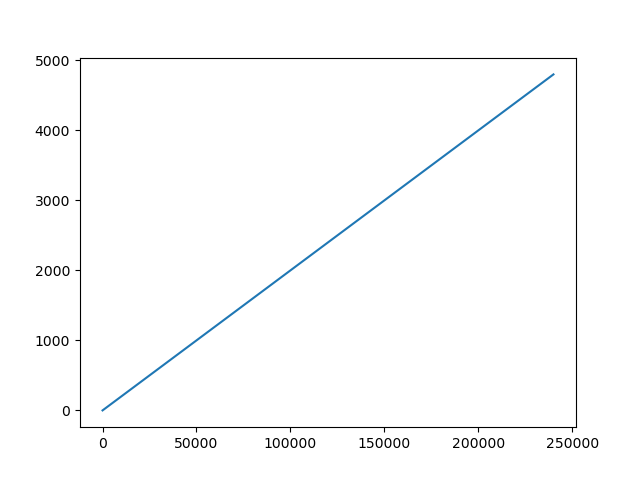

In [5]:
start = 40000
stop = 110000
# stop = 119000
# start = 160000
# stop = 240000
by = 1

plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)

In [6]:
stats = probes.statistics(
    names = [name for name in  probes.probe_names if "VolProbe" in name], 
    steps = [stop],
    quants = qoisOutputed,
    processing = None,
    parrallel=False
)
stats

processing data took 37 seconds


,"comp(u_avg,0)","comp(u_avg,1)","comp(u_avg,2)","comp(u_rms,0)","comp(u_rms,1)","comp(u_rms,2)",mag(u)_avg,mag(u)_rms
VolProbe0_0-0,0.435585,-0.002121,0.395488,0.336080,0.138214,0.318877,0.791502,0.308010
VolProbe0_0-1,0.539145,-0.008835,0.389679,0.371537,0.162272,0.346060,0.917437,0.338409
VolProbe0_0-2,0.343349,-0.003268,0.718413,0.351532,0.163444,0.362844,1.002460,0.344547
VolProbe0_0-3,0.216103,0.001522,0.708802,0.323649,0.166842,0.352219,0.925758,0.327581
VolProbe0_1-0,0.392058,0.000329,0.400807,0.348821,0.156179,0.342235,0.799248,0.318850
...,...,...,...,...,...,...,...,...
VolProbe9_2-3,1.122513,-0.032656,1.208152,0.379869,0.271126,0.347441,1.706552,0.393151
VolProbe9_3-0,1.279964,-0.041218,1.323670,0.397818,0.279712,0.371000,1.897117,0.423622
VolProbe9_3-1,1.121966,-0.024823,1.393834,0.394699,0.296021,0.383992,1.850646,0.419123
VolProbe9_3-2,0.812907,0.048630,1.061996,0.381696,0.291152,0.397765,1.418114,0.423942


In [7]:
def processVolProbeNames(s, pos = None):
    # Filter out any characters that are not digits, a decimal point, or a negative sign
    filtered = ''.join(c for c in s if c.isdigit() or c == '.' or c == '_')
    filtered = filtered.split('_')
    
    # Convert the filtered string to float
    if filtered:
        if pos is not None:
            return float(filtered[1][pos])
        else:
            return float(''.join(filtered[0]))

stats["lowerBound"] = stats.index.map(lambda s: processVolProbeNames(s))
stats["xPos"] = stats.index.map(lambda s: processVolProbeNames(s, pos=0))
stats["zPos"] = stats.index.map(lambda s: processVolProbeNames(s, pos=1))
stats.sort_values(by = ["xPos", "zPos", "lowerBound"], inplace=True)

stats["upperBound"] = stats["lowerBound"].copy()
maxBound = np.max(stats["upperBound"])
for i in range(stats.shape[0]):
    if stats["upperBound"].iloc[i] == maxBound:
        if category == "config2":
            stats["upperBound"].iloc[i] = 77.3
        elif category == "config3":
            stats["upperBound"].iloc[i] = 116
        else:
            raise Exception("Configuration {category} not an option")
    else:
        stats["upperBound"].iloc[i] = stats["lowerBound"].iloc[i+1]
stats.dropna(inplace=True)
stats["y"] = (stats["lowerBound"] + stats["upperBound"]) / 2
stats

,"comp(u_avg,0)","comp(u_avg,1)","comp(u_avg,2)","comp(u_rms,0)","comp(u_rms,1)","comp(u_rms,2)",mag(u)_avg,mag(u)_rms,lowerBound,xPos,zPos,upperBound,y
VolProbe0_0-0,0.435585,-0.002121,0.395488,0.336080,0.138214,0.318877,0.791502,0.308010,0.0,0.0,0.0,1.0,0.5
VolProbe1_0-0,0.500161,0.003227,0.521810,0.332807,0.211536,0.322641,0.890007,0.328950,1.0,0.0,0.0,2.0,1.5
VolProbe2_0-0,0.524238,0.000250,0.560417,0.335516,0.246085,0.332735,0.933123,0.340097,2.0,0.0,0.0,3.0,2.5
VolProbe3_0-0,0.592516,0.014537,0.644982,0.353360,0.266018,0.352398,1.024396,0.363428,3.0,0.0,0.0,4.0,3.5
VolProbe4_0-0,0.660293,0.013480,0.717292,0.364558,0.269539,0.361670,1.103965,0.378601,4.0,0.0,0.0,5.0,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
VolProbe72_3-3,2.006266,0.005180,2.251662,0.255185,0.200133,0.275438,3.030420,0.307068,72.0,3.0,3.0,76.0,74.0
VolProbe76_3-3,2.083035,-0.000896,2.310860,0.228904,0.191944,0.266274,3.124367,0.279390,76.0,3.0,3.0,84.0,80.0
VolProbe84_3-3,2.141606,-0.003816,2.372741,0.217190,0.182768,0.255239,3.207539,0.272515,84.0,3.0,3.0,92.0,88.0
VolProbe92_3-3,2.179476,0.002416,2.438399,0.187297,0.142334,0.212288,3.278627,0.217052,92.0,3.0,3.0,104.0,98.0


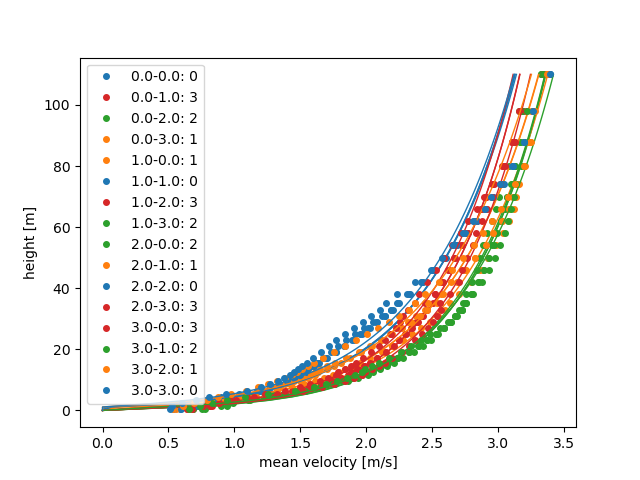

In [8]:
fig, ax = plt.subplots()
statsMI = stats.set_index(["xPos", "zPos", "y"])
c = 0
for xPos, dfx in statsMI.groupby(level=0):
    for zPos, df in dfx.groupby(level=1):
        qty_vol = quantities.Qty()
        meanU = np.sin(thetaRad) * df["comp(u_avg,0)"] + np.cos(thetaRad) * df["comp(u_avg,2)"]
        qty_vol.meanU = meanU#.iloc[6:27]
        qty_vol.y = df.index.get_level_values(2).values#[6:27]
        id = int((xPos-zPos)%4)
        ax = quantities.plot_ABL({f"{xPos}-{zPos}: {id}": qty_vol}, fit_disp=False, colorOffset=id, ax=ax)
        c += 1

## Probe Columns

In [5]:
qois = ['comp(u,0)', 'comp(u,2)']

probes = probePost.Probes(probes_dir, directory_parquet=oak_probes_dir, file_type = "csv")
# probes.to_parquet(overwrite=True)

# probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, file_type = "parquet")

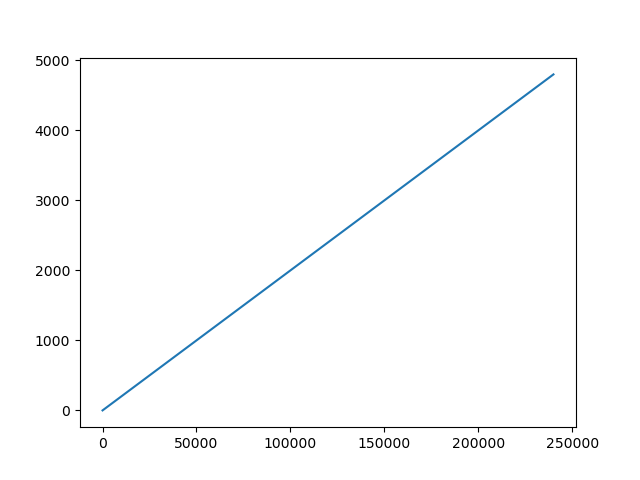

In [6]:
start = 40000
stop = 120000
by = 1

plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)

## Time Series

processing data took 54 seconds


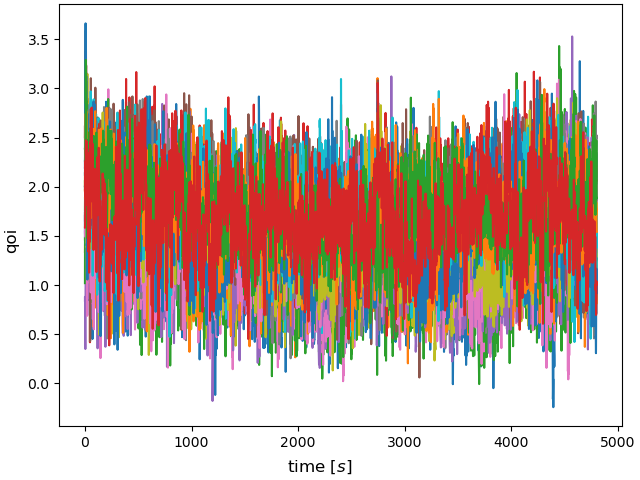

In [18]:
(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    # steps = probes.probe_steps[start:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'qoi',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        'plot every': 1000,
        'exclude legend': True
        },
    processing = [],
    parrallel=True,
    stack = [24],
    )


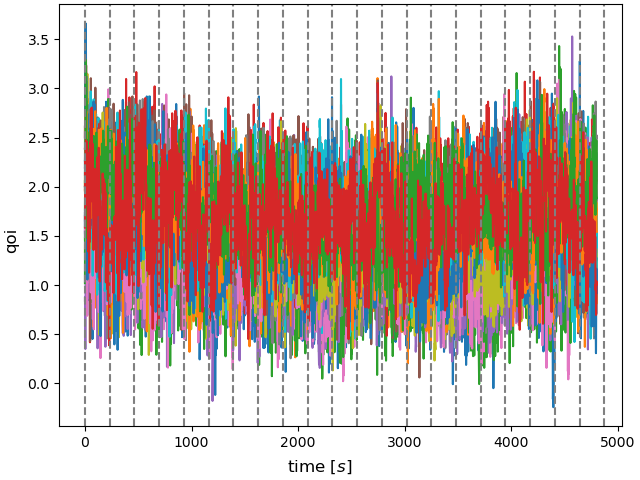

In [19]:

for i in range(0, 5000, 232):  # Adjust for the range you need
    ax.axvline(x=i, color='gray', linestyle='--')

plt.show()

## Plot ABL

In [19]:
qty_dict = probes.create_qty_dict(
    theta_wind = theta,
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    stack = range(1,40),
)

for k, v in qty_dict.items(): v.calc_stats()

processing data took 5 seconds
pressure data not founnd, replacing with zeros
processing data took 5 seconds
pressure data not founnd, replacing with zeros
processing data took 5 seconds
pressure data not founnd, replacing with zeros
processing data took 5 seconds
pressure data not founnd, replacing with zeros
processing data took 5 seconds
pressure data not founnd, replacing with zeros
processing data took 5 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 5 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 5 seconds
pressure data not founnd, replacing with zeros
processing data took 5 seconds
pressure data not founnd, replacing with zeros
processing data took 5 seconds
pressure data not founnd, replacing with zeros


<Axes: xlabel='mean velocity [m/s]', ylabel='height [m]'>

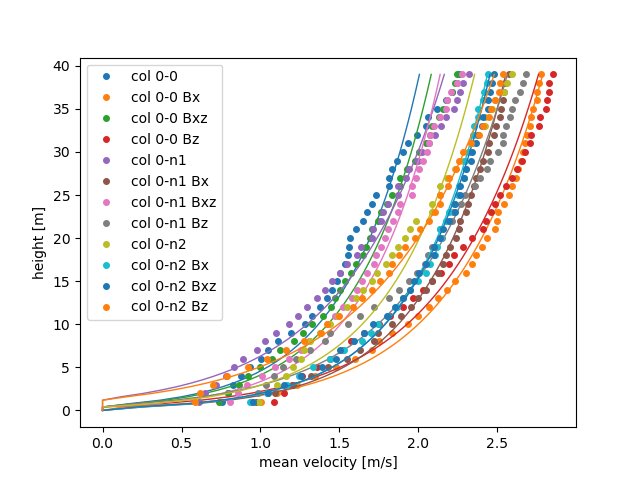

In [20]:
quantities.plot_ABL(qty_dict, fit_disp=True)


<Axes: xlabel='mean velocity [m/s]', ylabel='height [m]'>

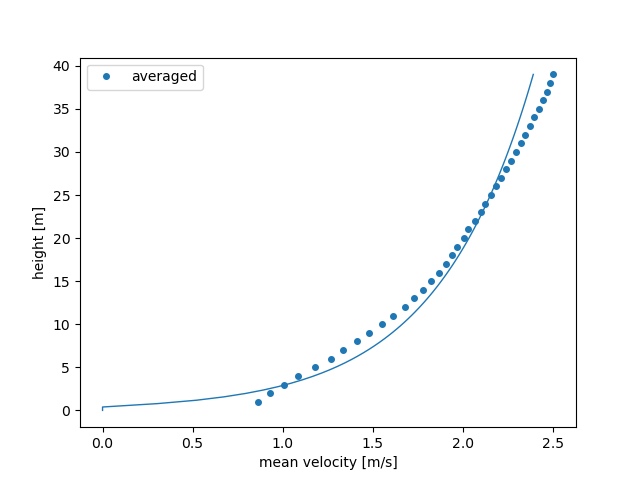

In [23]:
qty_total = quantities.Qty()
for i, (k, v) in enumerate(qty_dict.items()):
    if i == 0:
        qty_total.meanU = np.zeros_like(v.meanU)
        qty_total.y = v.y
    qty_total.meanU += v.meanU
qty_total.meanU /= len(qty_dict)

quantities.plot_ABL({"averaged": qty_total}, fit_disp=True)

## Plot Length Scales

/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,3)


(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'Lx'}, xlabel='y [m]', ylabel='L [m]'>,
        <Axes: title={'center': 'Ly'}, xlabel='y [m]'>,
        <Axes: title={'center': 'Lz'}, xlabel='y [m]'>], dtype=object))

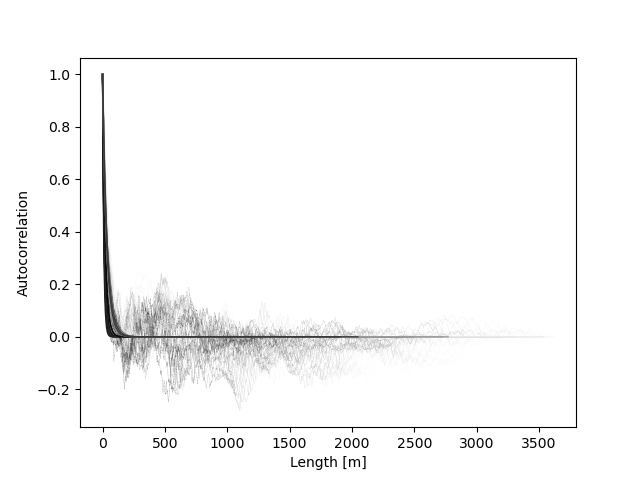

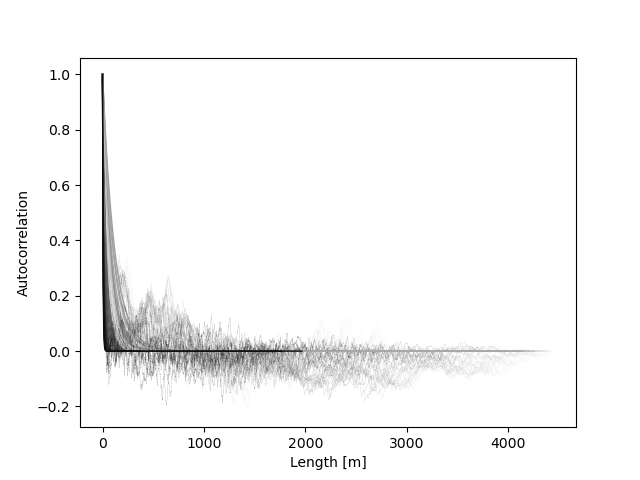

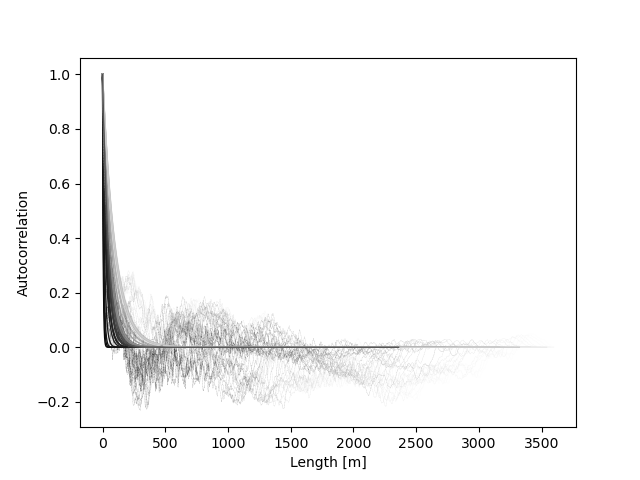

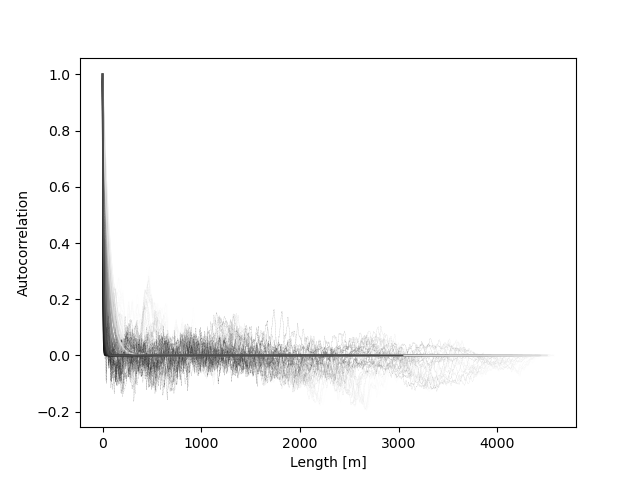

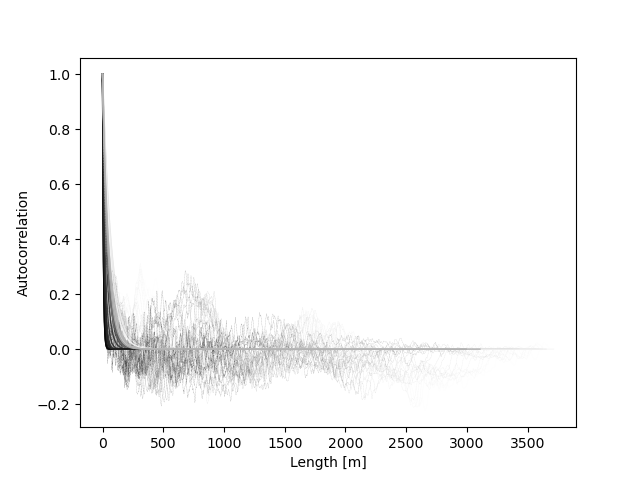

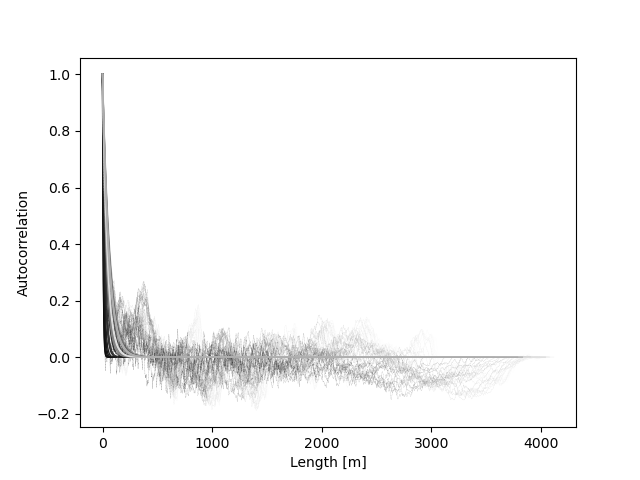

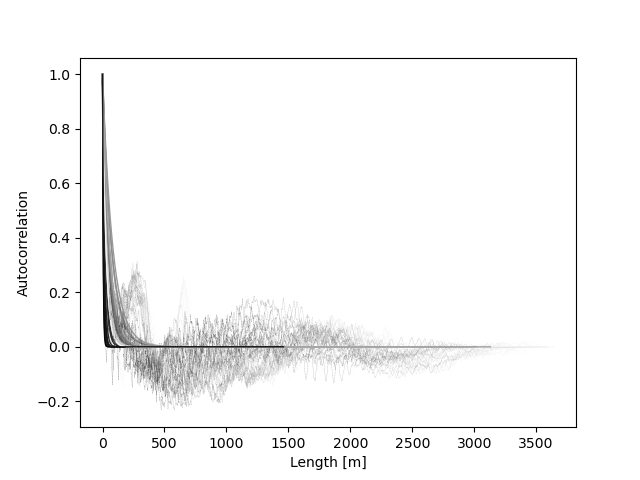

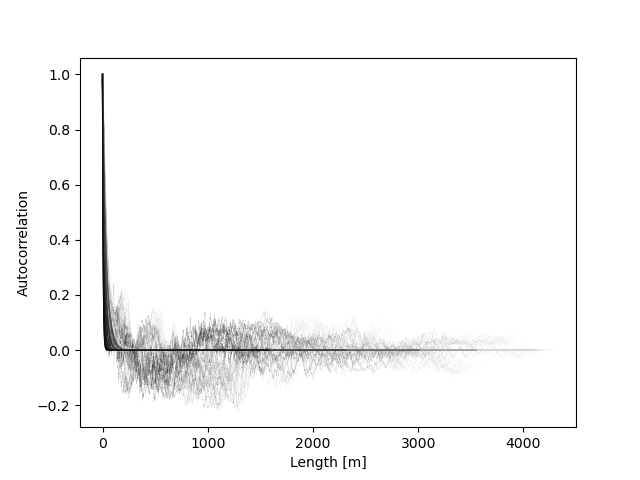

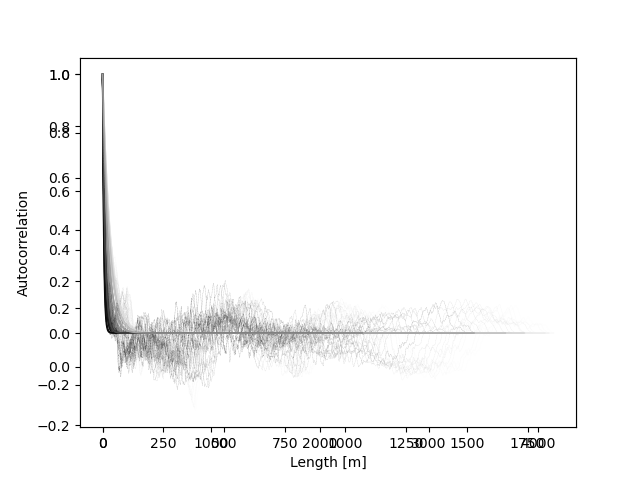

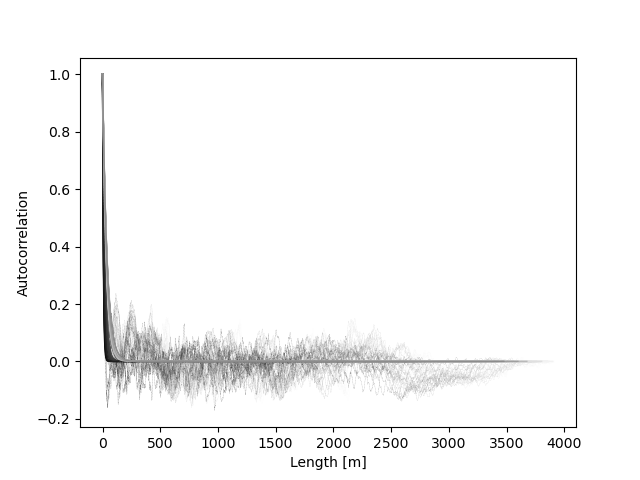

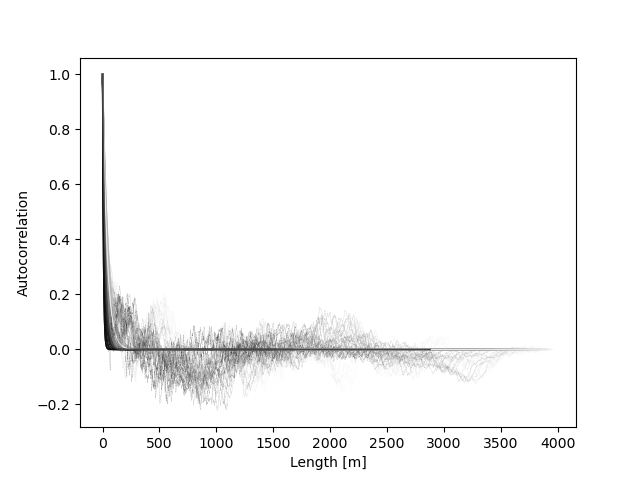

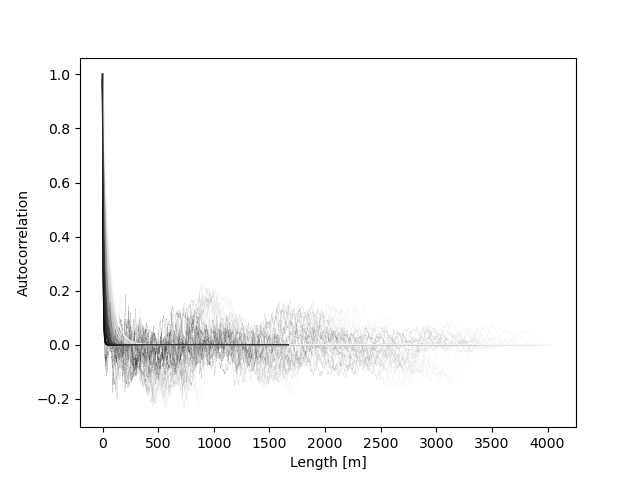

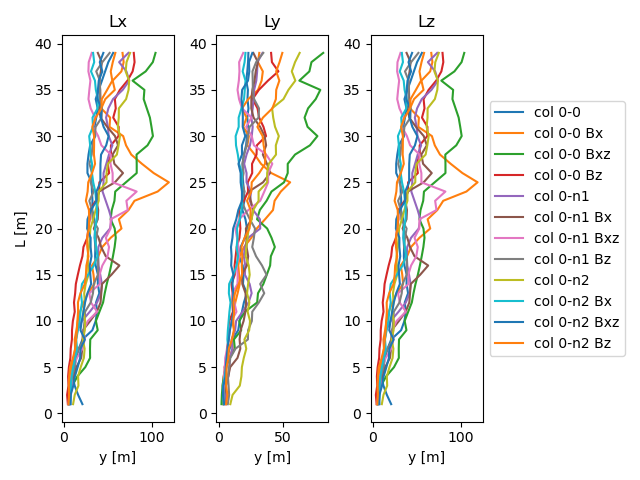

In [22]:
for k, v in qty_dict.items(): v.calc_scales()
quantities.plot_length_scales(qty_dict)

## Plot Reynolds stresses

(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'uu'}, ylabel='y [m]'>,
         <Axes: title={'center': 'vv'}>, <Axes: title={'center': 'ww'}>],
        [<Axes: title={'center': 'uv'}, ylabel='y [m]'>,
         <Axes: title={'center': 'uw'}, xlabel='Reynolds Stress [m^2/s^2]'>,
         <Axes: title={'center': 'vw'}>]], dtype=object))

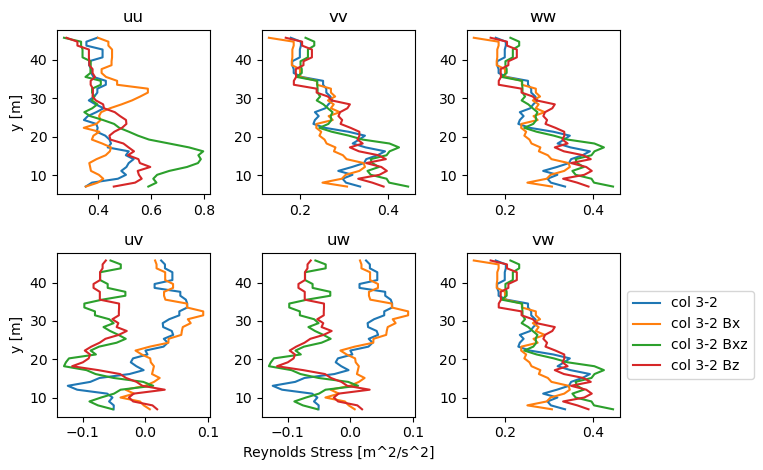

In [ ]:
quantities.plot_reynolds_stresses(qty_dict)

## Plot Turbulence Intensities

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='Iu', ylabel='y [m]'>, <Axes: xlabel='Iv'>,
        <Axes: xlabel='Iw'>], dtype=object))

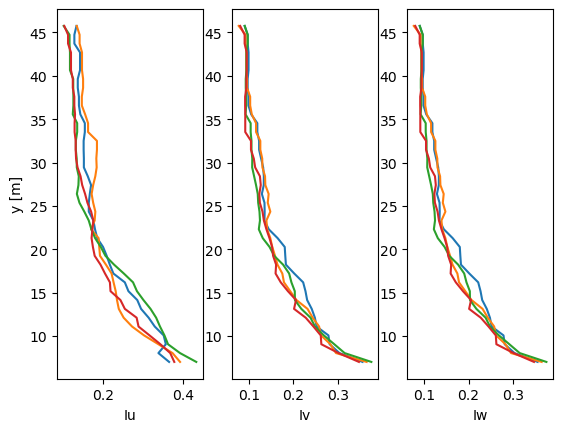

In [ ]:
quantities.plot_turbulence_intensities(qty_dict)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Prms [Pa]', ylabel='y [m]'>)

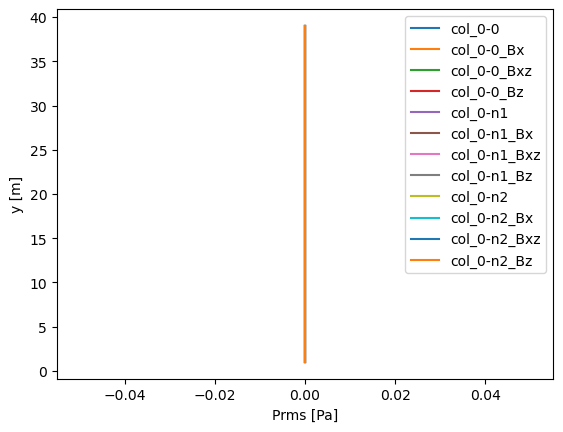

In [ ]:
quantities.plot_prms(qty_dict)

## Spectra

In [10]:
stack = [1, 10, 20, 30, 40, 50]

qty_dict = probes.create_qty_dict(
    theta_wind = theta,
    names = [name for name in  probes.probe_names if "col" in name][0:2],#[name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    stack = stack,
)

for k, v in qty_dict.items(): v.calc_spectra()

KeyboardInterrupt: 

/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:311: RuntimeWarning: divide by zero encountered in power
  ax.loglog(qty.f, initial_offset*qty.f**(eval(scaling)), label = scaling)


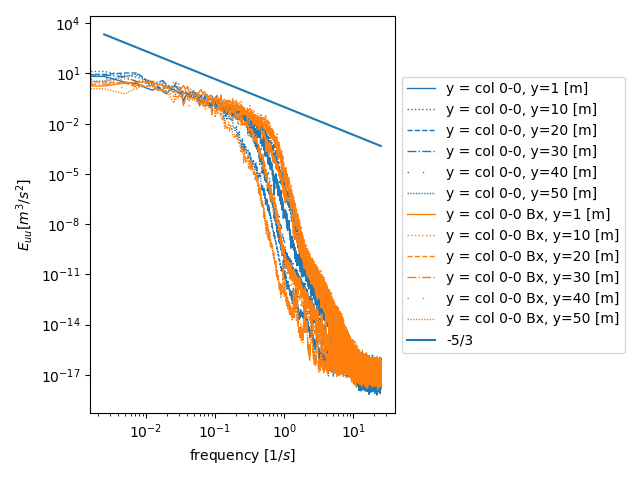

In [16]:
fig, ax = quantities.plot_power_spectra(qty_dict, var = 'Euu')

## Plot p_rms


/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:299: RuntimeWarning: divide by zero encountered in reciprocal
  ax.loglog(qty.f, initial_offset*qty.f**(eval(scaling)), label = scaling)


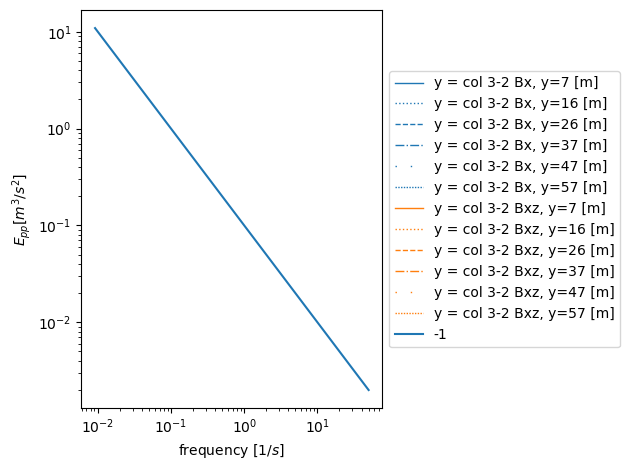

In [ ]:
fig, ax = quantities.plot_power_spectra(qty_dict, var = "Epp", scaling = "-1")